In [1]:
exp_name = None
exp_output_dir = None
exp_conf_dir = None
filter_code = None
nucleus_plasmid_threshold = .9
enable_graphics = True
enable_single_cell_data = False
export_dir = None

In [2]:
# Parameters
enable_single_cell_data = True
nucleus_plasmid_threshold = 0.9
exp_output_dir = "/lab/data/dna-stain/20180921-stain/20180921-D34-act-lab-60X-15by15/output/v00"
export_dir = "/lab/repos/cell-image-analysis/analysis/experiments/dna-stain/plasmid_analysis/renders/20180921-D34-act-lab-60X-15by15"
progres_bar = True
filter_code = "df = df[df['cs:Plasmid:class'] == 1]\ndf = df[df['ni:DAPI'] >= 50]\ndf = df[df['nucleus_diameter'].between(2, 15) & df['cell_diameter'].between(5, 20)]\ndf = df[df['cell_circularity'] > .8]\ndf = df[df['ci:PHA'] >= 30]"
exp_conf_dir = "/lab/repos/cell-image-analysis/config/experiment/dna-stain/20180921-stain/20180921-D34-act-lab-60X-15by15"
enable_graphics = True
exp_name = "20180921-D34-act-lab-60X-15by15"


In [3]:
# # Parameters
# exp_conf_dir = "/lab/repos/cell-image-analysis/config/experiment/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11"
# enable_graphics = False
# exp_output_dir = "/lab/data/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11/output/v00"
# filter_code = "df = df[df['cs:Plasmid:class'] == 1]\ndf = df[df['ci:PHA'] >= 30]\ndf = df[df['nucleus_diameter'].between(2, 15) & df['cell_diameter'].between(5, 20)]\ndf = df[df['cell_circularity'] > .8]\ndf = df[df['ni:DAPI'] >= 50]"
# exp_name = "20180911-D35-activated-labeled-60X-11by11"
# nucleus_plasmid_threshold = 0.9
# enable_single_cell_data = True

In [4]:
if filter_code and filter_code.lower() == 'none':
    filter_code = None

In [5]:
assert exp_name, 'Must provide "exp_name" (Experiment Name)'
assert exp_output_dir, 'Must provide "exp_conf_dir" (Experiment Output Directory)'
assert exp_conf_dir, 'Must provide "exp_conf_dir" (Experiment Configuration Directory)'

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import os.path
import os.path as osp
import papermill as pm
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from cytokit.function import data as cytokit_data
from cvutils import encoding
exp_conf = cytokit_config.load(exp_conf_dir)

In [7]:
# Compute size of field of view for experiment in sq mm
sqmm_ppx = (exp_conf.microscope_params.res_lateral_nm / 1e6)**2
sqmm_exp = sqmm_ppx * exp_conf.region_height * exp_conf.region_width * exp_conf.tile_width * exp_conf.tile_height
sqmm_exp

4.825032679182644

In [8]:
cyto_path = osp.join(exp_output_dir, cytokit_io.get_cytometry_agg_path('csv'))
df = pd.read_csv(cyto_path)
cell_density_raw = len(df) / sqmm_exp

In [9]:
if filter_code is not None:
    local_vars = {'df': df}
    exec(filter_code, globals(), local_vars)
    df = local_vars['df']
cell_density_target = len(df) / sqmm_exp
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 17 to 2939
Data columns (total 43 columns):
region_index                          85 non-null int64
tile_index                            85 non-null int64
tile_x                                85 non-null int64
tile_y                                85 non-null int64
rid                                   85 non-null int64
rx                                    85 non-null float64
ry                                    85 non-null float64
id                                    85 non-null int64
x                                     85 non-null float64
y                                     85 non-null float64
z                                     85 non-null int64
cell_size                             85 non-null float64
cell_diameter                         85 non-null float64
cell_perimeter                        85 non-null float64
cell_circularity                      85 non-null float64
cell_solidity                         

In [10]:
pm.record('cell_density_raw', cell_density_raw)
pm.record('cell_density_target', cell_density_target)
cell_density_raw, cell_density_target

(627.9750214071668, 17.616460996570687)

In [11]:
cts = df['cs:Plasmid:plasmid_count'].value_counts().sort_index()
print('Plasmid count distribution:')
pm.record('plasmid_count_dist', cts.to_json())
for i, v in cts.items():
    print(i, '-', v)

print('Num cells total:')
pm.record('total_cells', len(df))
len(df)

Plasmid count distribution:


1 - 42
2 - 21
3 - 13
4 - 5
5 - 2
6 - 1
7 - 1
Num cells total:


85

### Single Cell Export and Visualization

Single cell data frame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 15 columns):
id                         85 non-null int64
rid                        85 non-null int64
tile_x                     85 non-null int64
tile_y                     85 non-null int64
x                          85 non-null float64
y                          85 non-null float64
z                          85 non-null int64
cell_diameter              85 non-null float64
nucleus_diameter           85 non-null float64
cell_circularity           85 non-null float64
nucleus_circularity        85 non-null float64
nucleus_fraction           85 non-null object
nucleus_plasmid_count      85 non-null int64
cytoplasm_plasmid_count    85 non-null int64
image                      85 non-null object
dtypes: float64(6), int64(7), object(2)
memory usage: 10.0+ KB
None
Exporting data frame to csv


<Figure size 432x288 with 0 Axes>

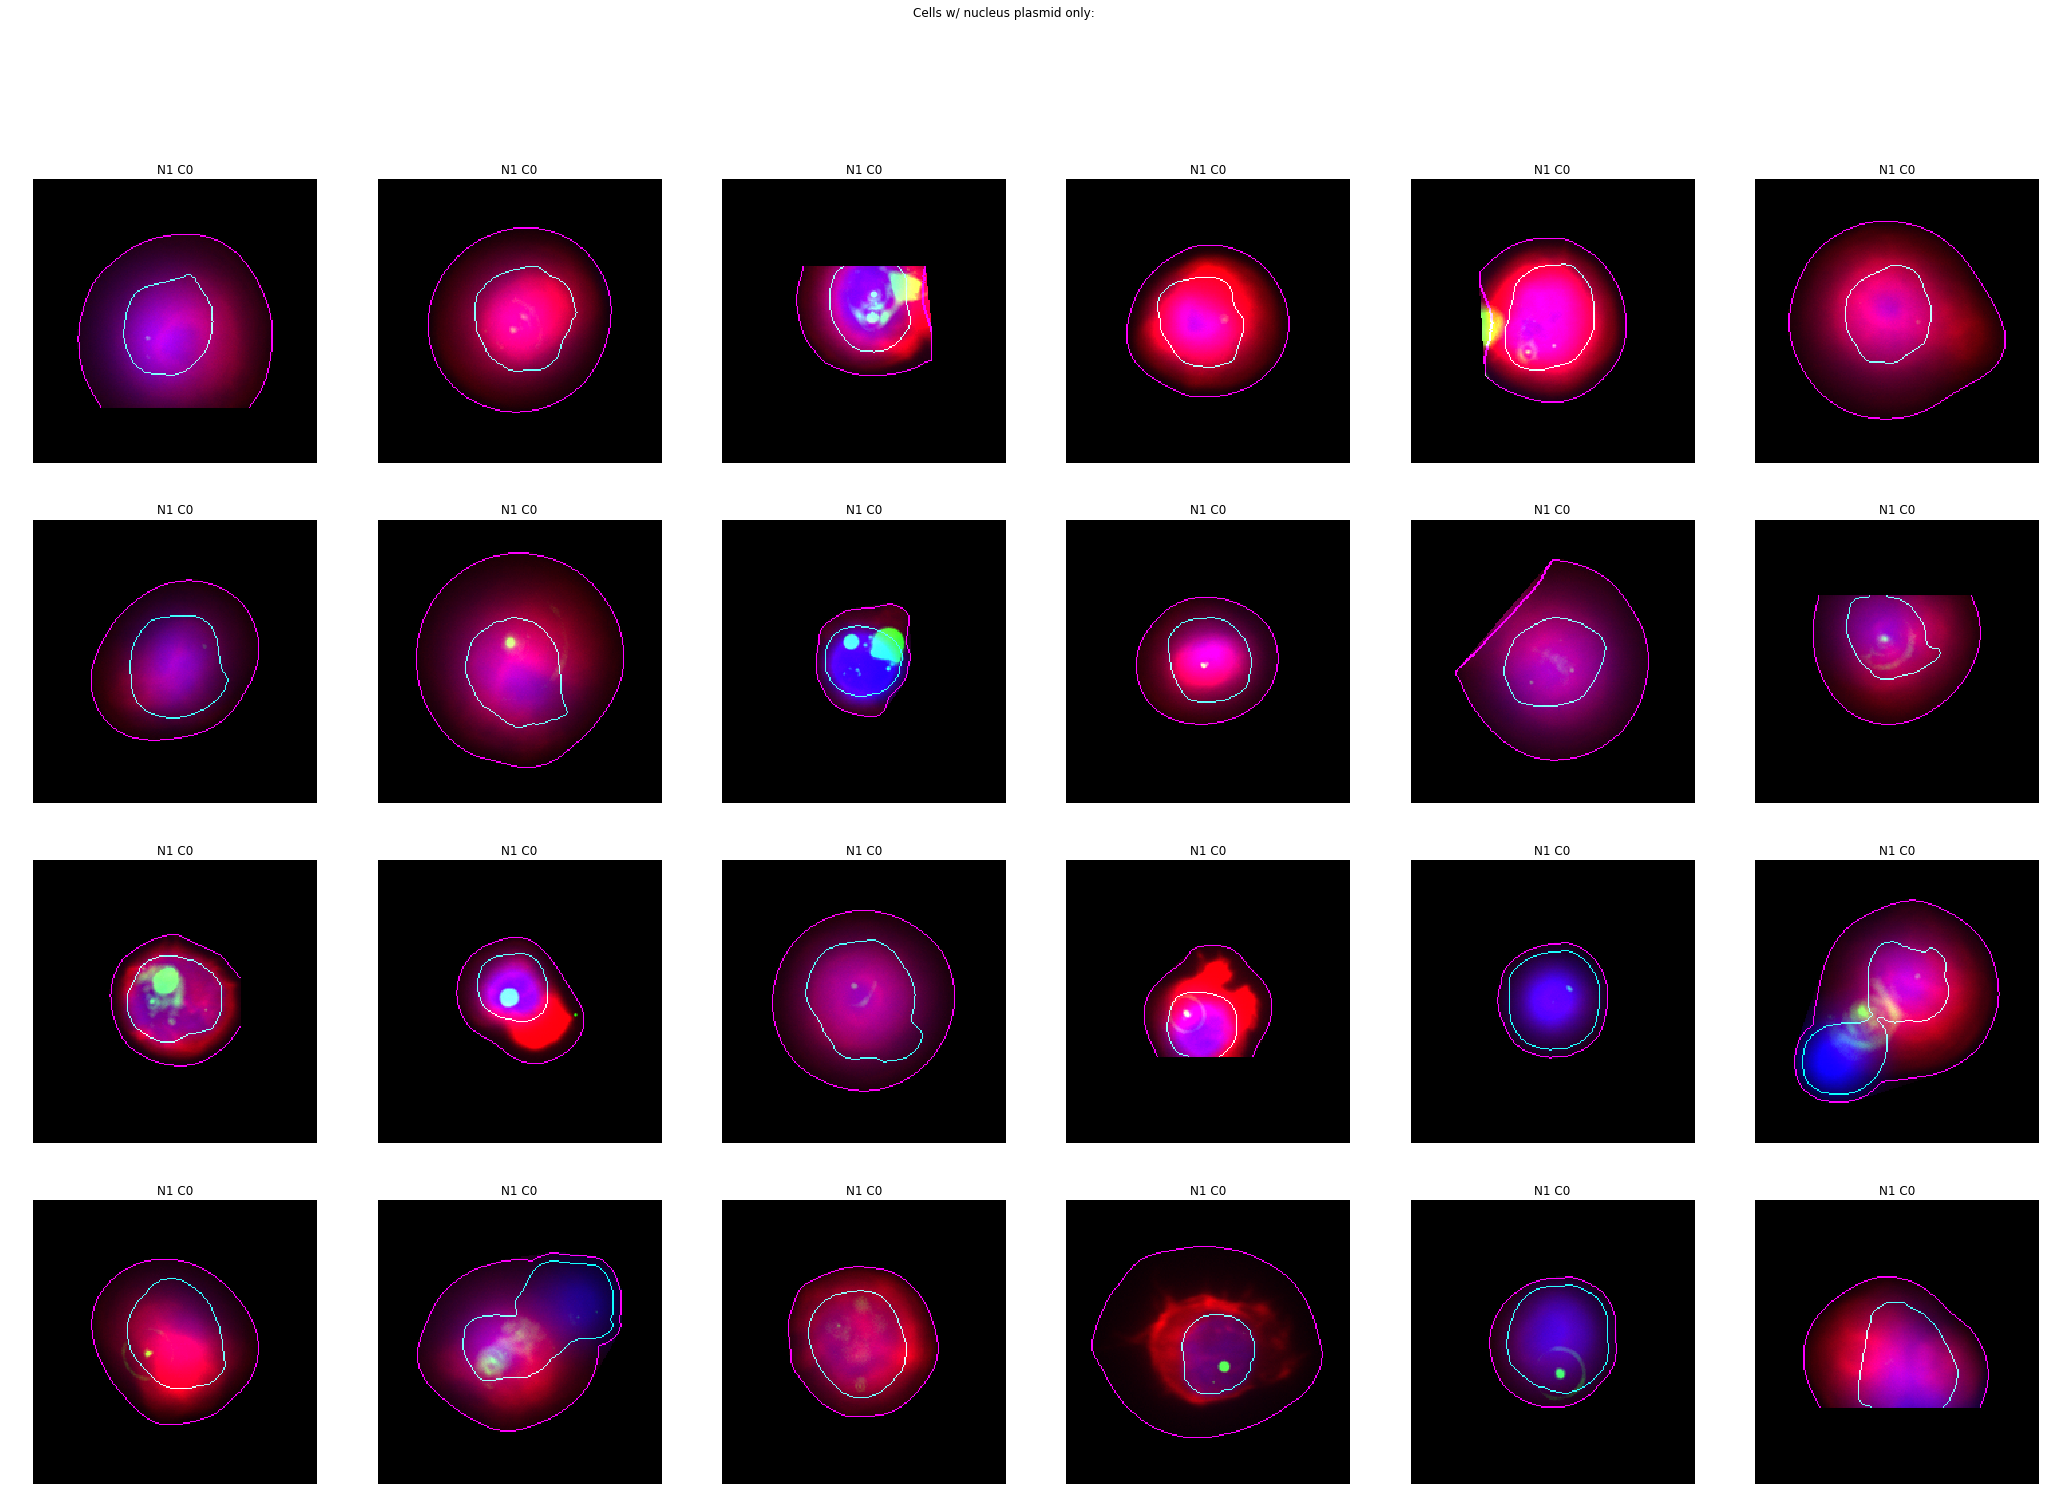

<Figure size 432x288 with 0 Axes>

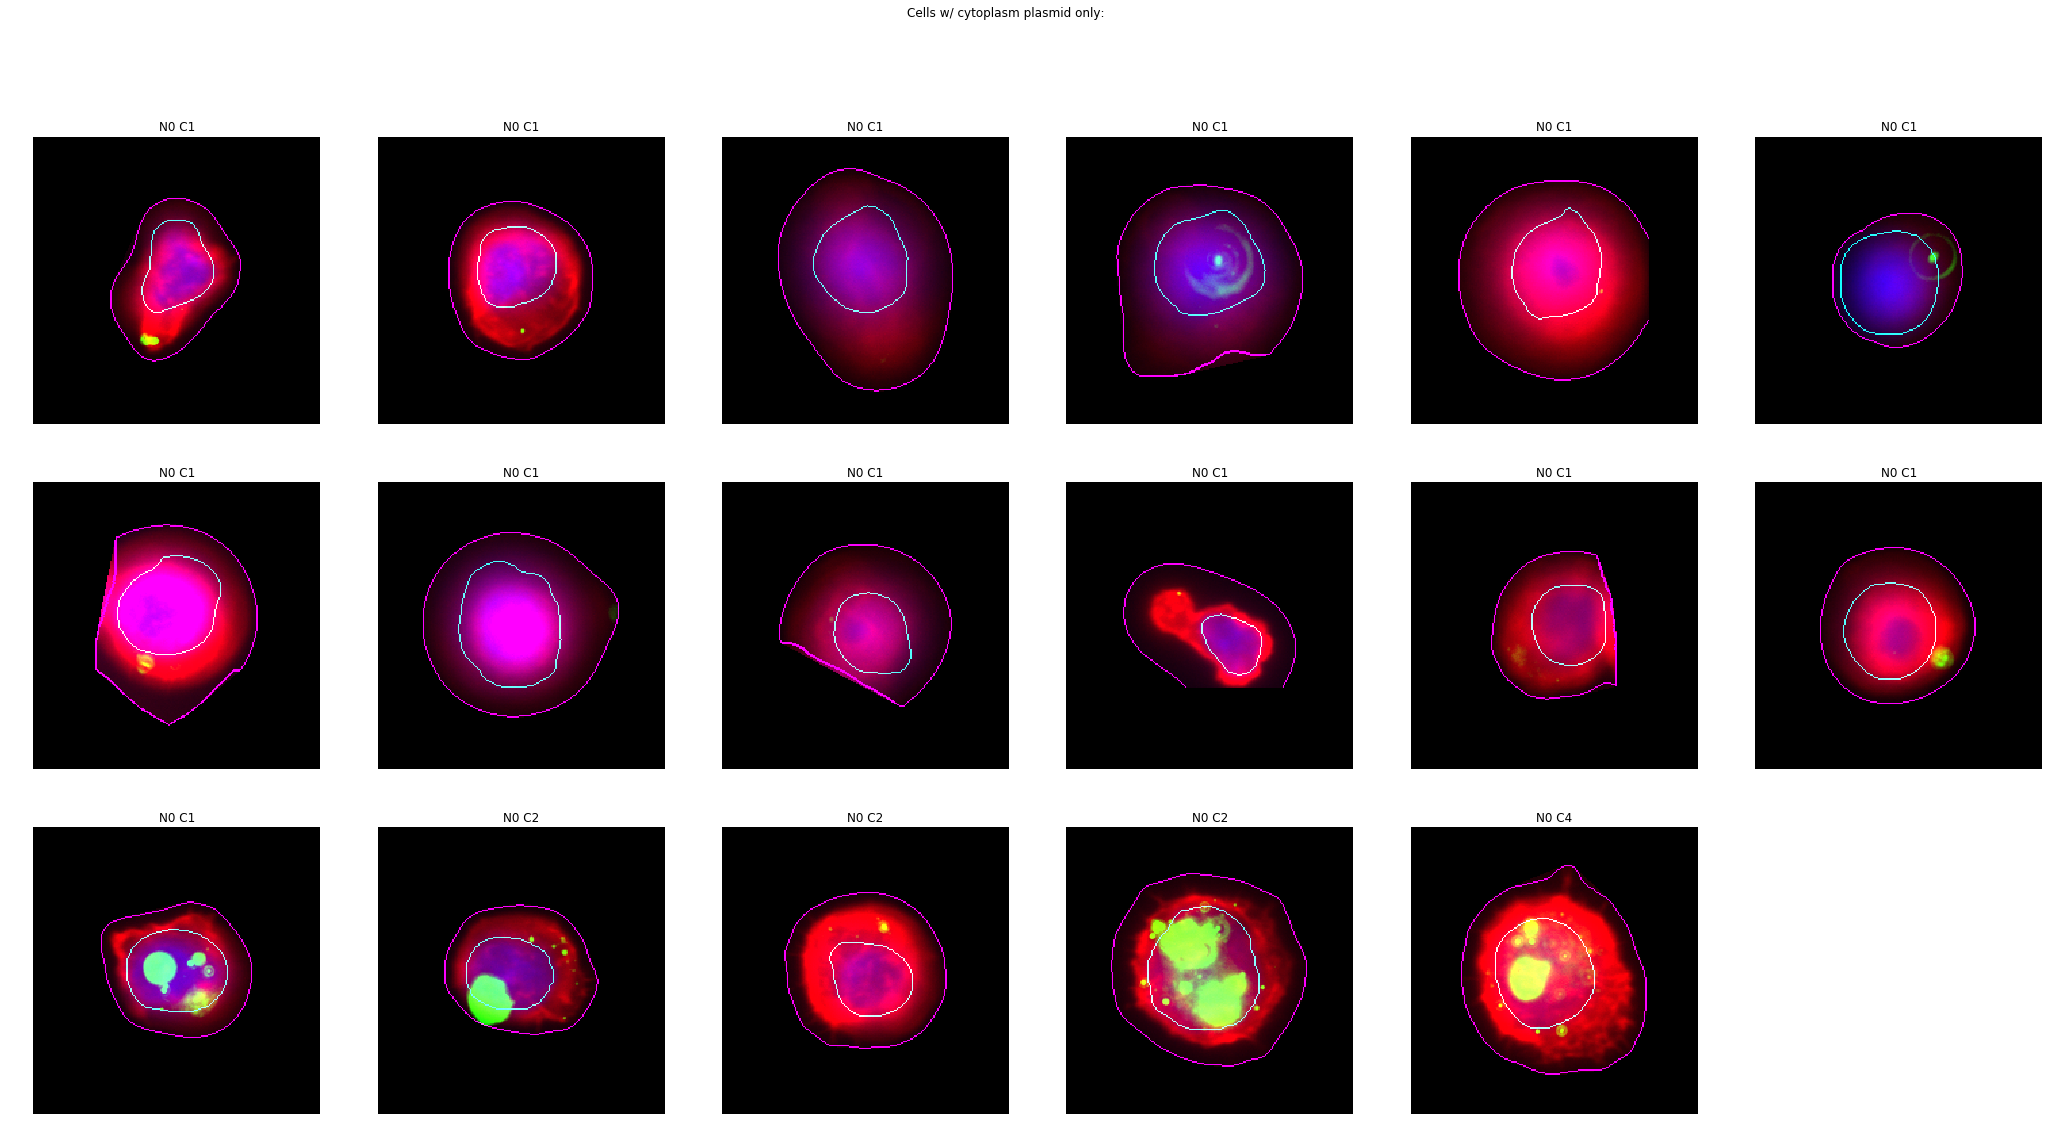

In [12]:
def plot_cells(df, ncol=6, title=''):
    n = len(df)
    plt.figure()
    nrow = -(-n//ncol)
    fig, axs = plt.subplots(nrow, ncol)
    fig.suptitle(title)
    fig.set_size_inches(ncol * 6, nrow * 6)
    axs = axs.ravel()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i in range(n):
        r = df.iloc[i]
        axs[i].imshow(r['image'])
        axs[i].set_title('N{} C{}'.format(r['nucleus_plasmid_count'], r['cytoplasm_plasmid_count']))

def disp():
    if not enable_single_cell_data:
        return None
    
    # Set display settings for overlay on single cell images
    thresh = exp_conf.cytometry_params['quantification_params']['spot_count_params']['threshold']
    ranges = {
        'proc_Plasmid': [thresh, 255],
        'proc_PHA': [0, 150],
        'cyto_nucleus_boundary': [0, 1],
        'cyto_cell_boundary': [0, 1]
    }
    colors = {
        'proc_DAPI': 'blue', 
        'proc_PHA': 'red', 
        'proc_Plasmid': 'green',
        'cyto_nucleus_boundary': 'cyan',
        'cyto_cell_boundary': 'magenta'
    }
    
    # Attach cell images to cytometry data frame
    dfsc = cytokit_data.get_single_cell_image_data(
        exp_output_dir, df, 'best_z_segm',
        ranges=ranges, colors=colors,
        image_size=(212, 212)
    )
    assert dfsc['image'].notnull().all()
    
    # Extract summary data 
    cols = [
        'id', 'rid', 'tile_x', 'tile_y', 'x', 'y', 'z', 
        'cell_diameter', 'nucleus_diameter',
        'cell_circularity', 'nucleus_circularity',
        'cs:Plasmid:nucleus_fraction', 
        'cs:Plasmid:nucleus_plasmid_count',
        'cs:Plasmid:cytoplasm_plasmid_count',
        'image'
    ]
    dfsc = dfsc[cols].rename(columns=lambda c: c.replace('cs:Plasmid:', ''))
    
    # Cherry-pick cells with ideal characteristics for visualization
    plot_cells(
        dfsc[(dfsc['nucleus_plasmid_count'] > 0) & (dfsc['cytoplasm_plasmid_count'] == 0)]\
        .sort_values('nucleus_plasmid_count').head(24),
        title='Cells w/ nucleus plasmid only:'
    )
    plot_cells(
        dfsc[(dfsc['cytoplasm_plasmid_count'] > 0) & (dfsc['nucleus_plasmid_count'] == 0)]\
        .sort_values('cytoplasm_plasmid_count').head(24),
        title='Cells w/ cytoplasm plasmid only:'
    )
    
    # Export to csv if export dir given
    if export_dir:
        dfsc['image'] = dfsc['image'].apply(encoding.base64_encode_image)
        print('Single cell data frame info:')
        print(dfsc.info())
        print('Exporting data frame to csv')
        path = osp.join(export_dir, 'data.csv')
        dfsc.to_csv(path, index=False)
    
disp()

### Individual Plasmid Analysis

In [13]:
def from_csv(v):
    if pd.isnull(v) or (len(v) == 0):
        return []
    return [float(x) for x in v.split(',')]

dfs = []
for i, r in df.iterrows():
    nuc_frac = np.array(from_csv(r['cs:Plasmid:nucleus_fraction']))
    assert np.all(nuc_frac <= 1)
    assert np.all(nuc_frac >= 0)
    for i in range(len(nuc_frac)):
        dfs.append((r['rid'], nuc_frac[i]))
dfs = pd.DataFrame(dfs, columns=['rid', 'nuc_frac'])
dfs.head()

,rid,nuc_frac
0,17,1.0
1,89,0.0
2,89,1.0
3,97,0.0
4,135,1.0


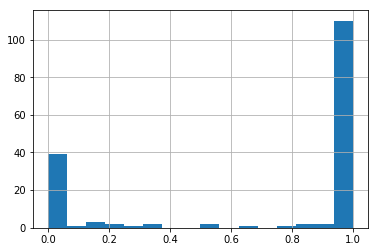

In [14]:
if enable_graphics:
    dfs['nuc_frac'].hist(bins=16)

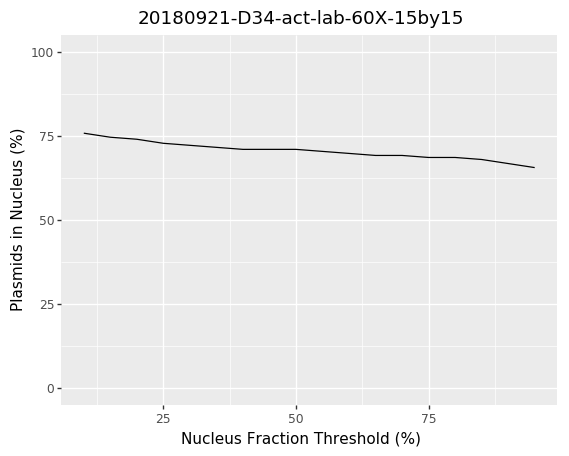

<ggplot: (8743702678806)>

In [15]:
def get_threshold_curve(dfs):
    df = []
    for thresh in np.arange(.1, 1., .05):
        p = (dfs['nuc_frac'] > thresh).mean()
        df.append((100*thresh, 100*p))
    return pd.DataFrame(df, columns=['threshold', 'p'])
    
dfsfrac = get_threshold_curve(dfs)
pm.record('nucleus_fraction_threshold', dfsfrac.set_index('threshold')['p'].to_json())

def disp():
    if not enable_graphics:
        return None
    return (
        pn.ggplot(dfsfrac, pn.aes(x='threshold', y='p')) + 
        pn.geom_line() + 
        pn.ylim(0, 100) + 
        pn.xlab('Nucleus Fraction Threshold (%)') + 
        pn.ylab('Plasmids in Nucleus (%)') +
        pn.ggtitle(exp_name)
    )
disp()

In [16]:
cts = (dfs['nuc_frac'] > nucleus_plasmid_threshold).value_counts()
pm.record('plasmids_in_nucleus:count', cts.to_json())
cts

True     111
False     55
Name: nuc_frac, dtype: int64

In [17]:
cts = (dfs['nuc_frac'] > nucleus_plasmid_threshold).value_counts(normalize=True)
pm.record('plasmids_in_nucleus:frac', cts.to_json())
cts

True     0.668675
False    0.331325
Name: nuc_frac, dtype: float64

In [18]:
desc = df['nucleus_diameter'].describe()
pm.record('nucleus_diameter', desc.to_json())
desc

count    85.000000
mean      9.019827
std       1.378764
min       5.306183
25%       8.106986
50%       9.055822
75%       9.885761
max      12.640546
Name: nucleus_diameter, dtype: float64

In [19]:
desc = df['cell_diameter'].describe()
pm.record('cell_diameter', desc.to_json())
desc

count    85.000000
mean     15.538488
std       2.397171
min       9.785354
25%      14.013695
50%      15.395938
75%      17.591173
max      19.868633
Name: cell_diameter, dtype: float64

In [20]:
desc = (df['nucleus_size'] / df['cell_size']).describe()
pm.record('nucleus_to_cell_ratio', desc.to_json())
desc

count    85.000000
mean      0.352950
std       0.108708
min       0.112707
25%       0.290221
50%       0.336009
75%       0.399464
max       0.735624
dtype: float64

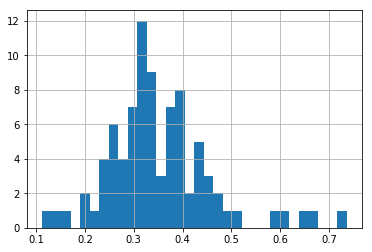

In [21]:
if enable_graphics:
    (df['nucleus_size'] / df['cell_size']).hist(bins=32)